<a href="https://colab.research.google.com/github/CarolinaOliveira001/SupremeCourtJudgementPrediction/blob/main/secondTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [5]:
df = pd.read_csv("justice.csv")
df = df[["facts", "issue_area", "first_party_winner"]]
df.head(5)

,facts,issue_area,first_party_winner
0,"<p>In 1970, Jane Roe (a fictional name used in...",NaN,True
1,<p>Joan Stanley had three children with Peter ...,Civil Rights,True
2,<p>John Giglio was convicted of passing forged...,Due Process,True
3,"<p>The Idaho Probate Code specified that ""male...",Civil Rights,True
4,"<p>Miller, after conducting a mass mailing cam...",First Amendment,True


In [6]:
df['issue_area'] = df['issue_area'].replace({"Due Process": "Others", "Privacy": "Others", "Federal Taxation": "Others", 
                                                     "Unions": "Others", "Federalism": "Others", "Attorneys": "Others",
                                                     "Miscellaneous": "Others", "Interstate Relations": "Others", "Private Action": "Others"})

In [7]:
df.isna().sum()

facts                   0
issue_area            142
first_party_winner     15
dtype: int64

In [8]:
df.dropna(subset=['first_party_winner'], inplace=True)

In [9]:
df.isna().sum()

facts                   0
issue_area            129
first_party_winner      0
dtype: int64

In [10]:
df_withNA = df[df['issue_area'].isna()]
df_withNA = df_withNA.reset_index(drop=True)

In [11]:
df_withoutNA = df.dropna(subset=['issue_area'])
df_withoutNA = df_withoutNA.reset_index(drop=True)

In [12]:
print("There are", df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 549349 words in the dataframe.


In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
pattern = r'[' + string.punctuation + ']'

def clean_text(text, stemming = False, lemmatization = False):
    """
        text: a string
        
        return: modified initial string
    """
    text = re.sub(pattern, " ", str(text))
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(' +', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    if stemming:
        st = PorterStemmer()
        text = " ".join([st.stem(w) for w in text.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        text = ' '.join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in text.split()])
    return text
    

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
df_withoutNA['facts'] = df_withoutNA['facts'].map(lambda x: clean_text(x, stemming=False, lemmatization = True))

In [18]:
df_withoutNA.head(3)

,facts,issue_area,first_party_winner
0,joan stanley three children peter stanley stan...,Civil Rights,True
1,john giglio convict pass forge money order app...,Others,True
2,idaho probate code specify males must prefer f...,Civil Rights,True


In [19]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 322095 words in the dataframe.


# Without deleting most frequent words

In [20]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [22]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 76.6 ms, sys: 0 ns, total: 76.6 ms
Wall time: 77.6 ms


In [23]:
list(set(y_pred))

['Others',
 'Criminal Procedure',
 'Economic Activity',
 'Civil Rights',
 'First Amendment']

In [24]:
list(set(y_test))

['Others',
 'Judicial Power',
 'Criminal Procedure',
 'Economic Activity',
 'Civil Rights',
 'First Amendment']

In [25]:
my_issue_area = list(set(df_withoutNA["issue_area"]))

In [26]:
import warnings
warnings.filterwarnings('always') #We can set it later to 'ignore'.

In [27]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.5580168776371308
                    precision    recall  f1-score   support

            Others       0.60      0.51      0.55       184
    Judicial Power       0.51      0.99      0.67       258
Criminal Procedure       0.64      0.63      0.64       161
 Economic Activity       0.84      0.17      0.28        96
      Civil Rights       0.00      0.00      0.00       111
   First Amendment       0.56      0.45      0.50       138

          accuracy                           0.56       948
         macro avg       0.53      0.46      0.44       948
      weighted avg       0.53      0.56      0.50       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [29]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 127 ms, sys: 70.1 ms, total: 197 ms
Wall time: 124 ms


In [30]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6867088607594937
                    precision    recall  f1-score   support

            Others       0.73      0.64      0.68       184
    Judicial Power       0.71      0.97      0.82       258
Criminal Procedure       0.66      0.73      0.69       161
 Economic Activity       0.71      0.76      0.73        96
      Civil Rights       0.61      0.21      0.31       111
   First Amendment       0.61      0.52      0.56       138

          accuracy                           0.69       948
         macro avg       0.67      0.64      0.63       948
      weighted avg       0.68      0.69      0.66       948



In [31]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [32]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 109 ms, sys: 104 ms, total: 213 ms
Wall time: 132 ms


In [33]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.689873417721519
                    precision    recall  f1-score   support

            Others       0.72      0.65      0.68       184
    Judicial Power       0.78      0.92      0.84       258
Criminal Procedure       0.68      0.69      0.69       161
 Economic Activity       0.70      0.73      0.71        96
      Civil Rights       0.51      0.34      0.41       111
   First Amendment       0.56      0.57      0.57       138

          accuracy                           0.69       948
         macro avg       0.66      0.65      0.65       948
      weighted avg       0.68      0.69      0.68       948



In [34]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [35]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 84.5 ms, sys: 0 ns, total: 84.5 ms
Wall time: 85.5 ms


In [36]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.49261603375527424
                    precision    recall  f1-score   support

            Others       0.53      0.34      0.41       184
    Judicial Power       0.56      0.94      0.70       258
Criminal Procedure       0.41      0.61      0.49       161
 Economic Activity       0.58      0.27      0.37        96
      Civil Rights       0.25      0.04      0.06       111
   First Amendment       0.36      0.24      0.29       138

          accuracy                           0.49       948
         macro avg       0.45      0.41      0.39       948
      weighted avg       0.46      0.49      0.44       948



In [37]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [38]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 80.7 ms, sys: 0 ns, total: 80.7 ms
Wall time: 82 ms


In [39]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6023206751054853
                    precision    recall  f1-score   support

            Others       0.54      0.57      0.56       184
    Judicial Power       0.70      0.90      0.79       258
Criminal Procedure       0.58      0.58      0.58       161
 Economic Activity       0.68      0.53      0.60        96
      Civil Rights       0.46      0.23      0.31       111
   First Amendment       0.49      0.46      0.47       138

          accuracy                           0.60       948
         macro avg       0.58      0.55      0.55       948
      weighted avg       0.59      0.60      0.59       948



In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [41]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [42]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [43]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 123 ms, sys: 1.07 ms, total: 124 ms
Wall time: 126 ms


In [44]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.630801687763713
                    precision    recall  f1-score   support

            Others       0.69      0.57      0.62       184
    Judicial Power       0.73      0.89      0.80       258
Criminal Procedure       0.59      0.60      0.59       161
 Economic Activity       0.61      0.69      0.64        96
      Civil Rights       0.52      0.29      0.37       111
   First Amendment       0.47      0.50      0.48       138

          accuracy                           0.63       948
         macro avg       0.60      0.59      0.59       948
      weighted avg       0.62      0.63      0.62       948



# With deleting some words

In [45]:
bunchOfWords = "".join(df_withoutNA["facts"].tolist())

We will perform a bag of words and try to find the words that appear 1000

In [46]:
data_corpus = set()
for word in bunchOfWords.split(" "):
    if word not in data_corpus: 
        data_corpus.add(word)
data_corpus=sorted(data_corpus)

In [47]:
def convert(set):
    return [*set, ]

data_corpus = convert(data_corpus)

In [48]:
one_hot_encoding = []
split = bunchOfWords.split(" ")
for word in data_corpus:
    count = split.count(word) 
    if word in split:
        one_hot_encoding.append(count)
    else:
        one_hot_encoding.append(count)

In [49]:
dfWords = pd.DataFrame({"words": data_corpus, "numberOfFrequency": one_hot_encoding})
dfWords["numberOfFrequency"] = pd.to_numeric(dfWords["numberOfFrequency"])

In [50]:
irrelevantWords = dfWords[dfWords["numberOfFrequency"] > 1000]
irrelevantWords = set(irrelevantWords["words"])

In [51]:
def more_clean_text(text):
    text = ' '.join(word for word in text.split() if word not in irrelevantWords) # delete stopwors from text
    return text

In [52]:
df_withoutNA['facts'] = df_withoutNA['facts'].apply(more_clean_text)

In [53]:
print("There are",df_withoutNA['facts'].apply(lambda x: len(x.split(' '))).sum(), "words in the dataframe.")

There are 267703 words in the dataframe.


In [54]:
X = df_withoutNA.facts
y = df_withoutNA.issue_area
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

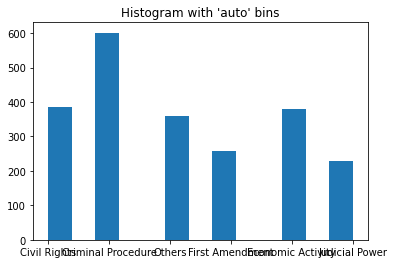

In [55]:
import matplotlib.pyplot as plt
_ = plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

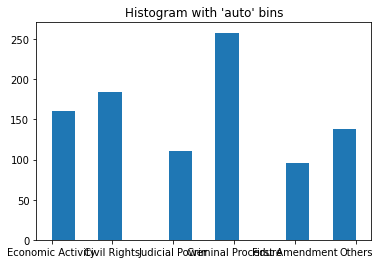

In [56]:
import matplotlib.pyplot as plt
_ = plt.hist(y_test, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [58]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 76.2 ms, sys: 0 ns, total: 76.2 ms
Wall time: 77.3 ms


In [59]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_issue_area))

accuracy 0.569620253164557
                    precision    recall  f1-score   support

            Others       0.61      0.53      0.56       184
    Judicial Power       0.53      0.99      0.69       258
Criminal Procedure       0.63      0.67      0.65       161
 Economic Activity       0.83      0.20      0.32        96
      Civil Rights       0.00      0.00      0.00       111
   First Amendment       0.54      0.44      0.48       138

          accuracy                           0.57       948
         macro avg       0.52      0.47      0.45       948
      weighted avg       0.53      0.57      0.51       948



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [61]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 111 ms, sys: 70 ms, total: 181 ms
Wall time: 103 ms


In [62]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.680379746835443
                    precision    recall  f1-score   support

            Others       0.71      0.64      0.67       184
    Judicial Power       0.69      0.96      0.81       258
Criminal Procedure       0.66      0.73      0.69       161
 Economic Activity       0.69      0.75      0.72        96
      Civil Rights       0.61      0.21      0.31       111
   First Amendment       0.64      0.49      0.55       138

          accuracy                           0.68       948
         macro avg       0.67      0.63      0.63       948
      weighted avg       0.67      0.68      0.66       948



In [63]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs', max_iter=100000)),
               ])
logreg.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=100000.0, max_iter=100000, n_jobs=1))])

In [64]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 97.6 ms, sys: 108 ms, total: 205 ms
Wall time: 133 ms


In [65]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6772151898734177
                    precision    recall  f1-score   support

            Others       0.70      0.65      0.67       184
    Judicial Power       0.77      0.91      0.84       258
Criminal Procedure       0.67      0.66      0.66       161
 Economic Activity       0.69      0.76      0.72        96
      Civil Rights       0.46      0.30      0.36       111
   First Amendment       0.55      0.55      0.55       138

          accuracy                           0.68       948
         macro avg       0.64      0.64      0.63       948
      weighted avg       0.66      0.68      0.67       948



In [66]:
from sklearn.ensemble import RandomForestClassifier

randfor = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators= 10, max_depth=10, random_state=10)),
               ])
randfor.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=10,
                                        random_state=10))])

In [67]:
%%time
y_pred = randfor.predict(X_test)

CPU times: user 78.7 ms, sys: 45 µs, total: 78.7 ms
Wall time: 79.3 ms


In [68]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.45358649789029537
                    precision    recall  f1-score   support

            Others       0.49      0.31      0.38       184
    Judicial Power       0.47      0.96      0.63       258
Criminal Procedure       0.37      0.42      0.39       161
 Economic Activity       0.71      0.25      0.37        96
      Civil Rights       0.53      0.07      0.13       111
   First Amendment       0.33      0.20      0.25       138

          accuracy                           0.45       948
         macro avg       0.48      0.37      0.36       948
      weighted avg       0.47      0.45      0.40       948



In [69]:
from sklearn.ensemble import GradientBoostingClassifier
graboos = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=10)),
               ])
graboos.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=10))])

In [70]:
%%time
y_pred = graboos.predict(X_test)

CPU times: user 65.4 ms, sys: 1.85 ms, total: 67.3 ms
Wall time: 69.4 ms


In [71]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6160337552742616
                    precision    recall  f1-score   support

            Others       0.55      0.58      0.56       184
    Judicial Power       0.72      0.91      0.81       258
Criminal Procedure       0.58      0.59      0.58       161
 Economic Activity       0.67      0.57      0.62        96
      Civil Rights       0.49      0.24      0.33       111
   First Amendment       0.51      0.46      0.48       138

          accuracy                           0.62       948
         macro avg       0.59      0.56      0.56       948
      weighted avg       0.60      0.62      0.60       948



In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [73]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [74]:
import xgboost as xgb

xgboo = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', xgb.XGBClassifier()),
               ])
xgboo.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(objective='multi:softprob'))])

In [75]:
%%time
y_pred = xgboo.predict(X_test)

CPU times: user 102 ms, sys: 2.91 ms, total: 105 ms
Wall time: 105 ms


In [76]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_issue_area))

accuracy 0.6234177215189873
                    precision    recall  f1-score   support

            Others       0.66      0.54      0.60       184
    Judicial Power       0.73      0.88      0.80       258
Criminal Procedure       0.60      0.61      0.61       161
 Economic Activity       0.67      0.66      0.66        96
      Civil Rights       0.47      0.29      0.36       111
   First Amendment       0.45      0.50      0.47       138

          accuracy                           0.62       948
         macro avg       0.60      0.58      0.58       948
      weighted avg       0.62      0.62      0.61       948



# Word2Vec

In [77]:
pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [81]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_withoutNA["facts"],df_withoutNA["issue_area"],test_size=0.2,shuffle=True)

In [86]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [87]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [88]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [89]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size = 32)

Epoch 1/2
79/79 [==============================] - 1046s 13s/step - loss: -14.1247 - accuracy: 0.2695
Epoch 2/2
79/79 [==============================] - 1030s 13s/step - loss: -42.5950 - accuracy: 0.2699


In [92]:
y_train

array([3, 2, 0, ..., 1, 0, 1])

In [90]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
print(y_predicted)

20/20 [==============================] - 265s 13s/step
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [93]:
y_predicted = model.predict(X_test)

20/20 [==============================] - 271s 13s/step


In [ ]:
y_predicted = y_predicted.flatten()
print(y_predicted)

In [95]:
print('accuracy %s' % accuracy_score(y_predicted, y_test))
print(classification_report(y_test, y_predicted,target_names=my_issue_area))

accuracy 0.2800632911392405
                    precision    recall  f1-score   support

            Others       0.00      0.00      0.00       106
    Judicial Power       0.28      1.00      0.44       177
Criminal Procedure       0.00      0.00      0.00       125
 Economic Activity       0.00      0.00      0.00        56
      Civil Rights       0.00      0.00      0.00        66
   First Amendment       0.00      0.00      0.00       102

          accuracy                           0.28       632
         macro avg       0.05      0.17      0.07       632
      weighted avg       0.08      0.28      0.12       632



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
